In [1]:
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt

from numpy import array
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

articles_file = "articulos.json"
path_to_file = "../data/"
data = pd.read_json(os.path.join(path_to_file,articles_file))

Exploración inicial de los datos, balanceo del conjunto de datos

In [2]:
data.head()

articulo categoria
0  Los socialistas lo que sí quieren es dar a ese...  politica
1  "No me han pagado como merecía", ha dicho Mari...  politica
2  En asuntos como la unidad de España "es obliga...  politica
3  El juez Eloy Velasco, que instruyó causas de c...  politica
4  El presidente del Gobierno en funciones, Pedro...  politica

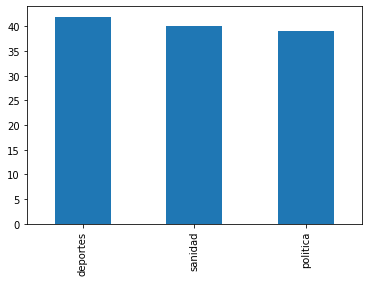

In [3]:
data.categoria.value_counts().plot(kind='bar')

Wordclouds con los terminos mas usados en las tres categorias

In [4]:
from stop_words import get_stop_words
import json
import re


# Read the file in dictionary format
with open(os.path.join(path_to_file,articles_file), "r", encoding="utf8") as file:
    articles = json.load(file)
    
word_counts = {}
for category in data.categoria.unique():
    word_counts[category] = []

# Obtenemos los caracteres alfanumericos y evitamos las stop-words
for article in articles:
    for w in re.findall(r"[\w']+", article['articulo']):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " ":
            word_counts[article['categoria']].append(w.lower())
            
for k,v in word_counts.items():
    print(f"La categoría {k} tiene {len(set(v))} palabras unicas de un total de {len(v)}" )
    


La categoría politica tiene 1467 palabras unicas de un total de 2869
La categoría deportes tiene 2032 palabras unicas de un total de 3883
La categoría sanidad tiene 1310 palabras unicas de un total de 2027


Imprimimos el top 10 terminos para cada categoria

In [5]:
for k,v in word_counts.items():
    # initializing a dictionary
    d = {}

    # counting number of times each word comes up in list of words
    for key in v: 
        d[key] = d.get(key, 0) + 1

    print(f"Top 10 terminos {k} (apariciones): ")

    for e in sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]:
        print(f"    - {e[0]} ({e[1]})")
        
    for _ in range(2): print()

Top 10 terminos politica (apariciones): 
    - gobierno (47)
    - congreso (33)
    - investidura (28)
    - sánchez (25)
    - psoe (20)
    - política (20)
    - españa (19)
    - catalunya (18)
    - pp (16)
    - erc (15)


Top 10 terminos deportes (apariciones): 
    - 1 (35)
    - puntos (31)
    - 0 (31)
    - partido (28)
    - min (28)
    - equipo (27)
    - tras (24)
    - parte (24)
    - club (20)
    - mientras (19)


Top 10 terminos sanidad (apariciones): 
    - salud (45)
    - enfermedad (14)
    - riesgo (10)
    - cáncer (10)
    - personas (9)
    - ser (9)
    - hospital (8)
    - años (8)
    - obesidad (8)
    - forma (8)




Guardamos un documento por cada categoria

In [6]:
for k,v in word_counts.items():
    with open(os.path.join(path_to_file,f"{k}.txt"), "w") as t:
        for w in v:
            if w.lower() not in get_stop_words("spanish"):
                t.write(w + " ")

Imprimimos el wordcloud

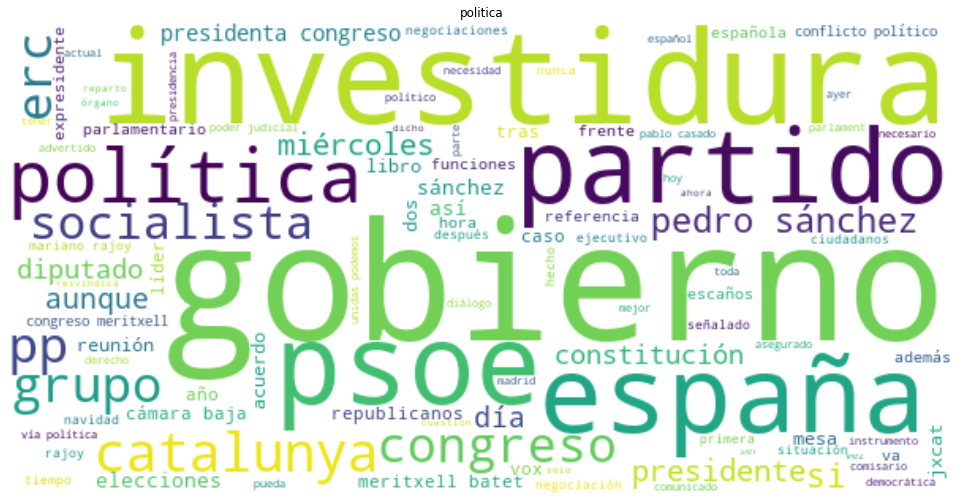

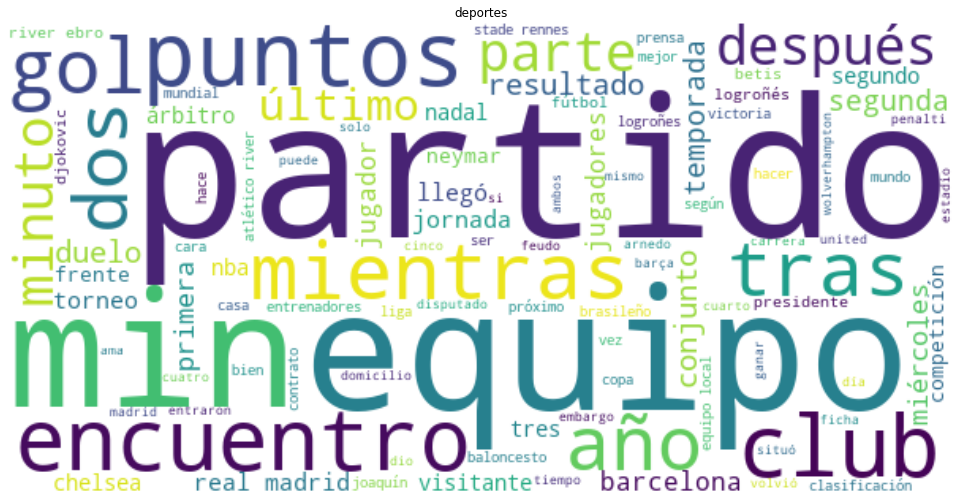

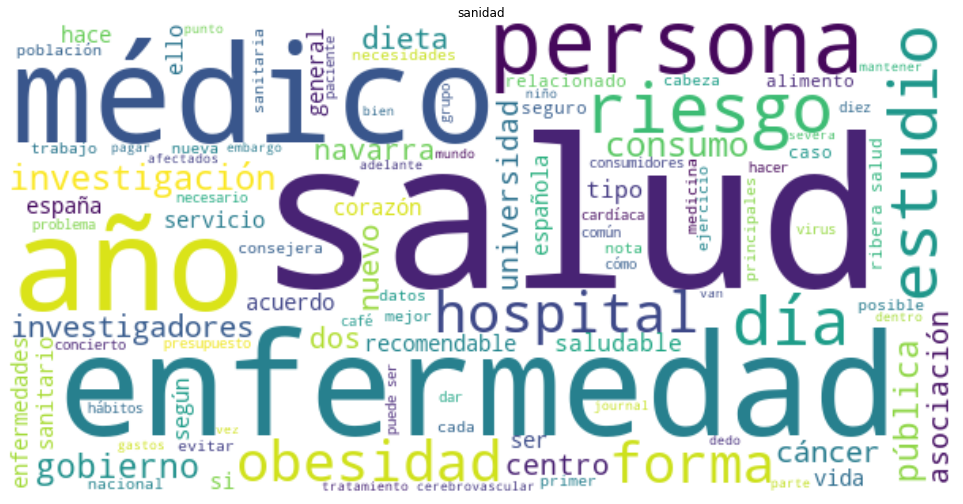

In [7]:
from wordcloud import WordCloud

wclouds = {}
for k in word_counts.keys():
    text = open(os.path.join(path_to_file,f"{k}.txt")).read()
    wclouds[k] = WordCloud(background_color="white", max_words=100, width=600, height=300, random_state=1).generate(text)
    
    plt.figure(figsize=(17,11))
    plt.title(k)
    plt.imshow(wclouds[k], interpolation='bilinear')
    plt.axis("off")


Seleccionamos las top 100 palabras de cada uno de los temas y de ellas seleccionamos un conjunto disjunto

In [8]:
glosario = {}
for k in word_counts.keys():
    glosario[k] = []

for k,v in word_counts.items():
    # initializing a dictionary
    d = {}

    # counting number of times each word comes up in list of words
    for key in v: 
        d[key] = d.get(key, 0) + 1

    for e in sorted(d.items(), key = lambda x: x[1], reverse = True)[:100]:
        glosario[k].append(e[0])


Seleccionamos un conjunto disjunto de palabras para cada uno de los tres temas

In [9]:
curated_glosario = {}
curated_glosario['sanidad'] = list( set( glosario['sanidad'] ) - set( glosario['deportes'] + glosario['politica'] ) )
curated_glosario['deportes'] = list( set( glosario['deportes'] ) - set( glosario['sanidad'] + glosario['politica'] ) )
curated_glosario['politica'] = list( set( glosario['politica'] ) - set( glosario['deportes'] + glosario['sanidad'] ) )

for k,v in curated_glosario.items():
    print(f"La categoria {k} tiene un glosario de {len(v)} terminos disjuntos")

La categoria sanidad tiene un glosario de 82 terminos disjuntos
La categoria deportes tiene un glosario de 82 terminos disjuntos
La categoria politica tiene un glosario de 78 terminos disjuntos


In [10]:
def get_curated_article(art):
    res = []
    for w in re.findall(r"[\w']+", art):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " ":
            res.append(w)
    
    return " ".join(res)


def get_curated_article_glossary(art, glossary):
    res = []
    for w in re.findall(r"[\w']+", art):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " " and w.lower() in glossary:
            res.append(w)
            
    return " ".join(res)


glosario_final = []
for v in curated_glosario.values():
    for w in v:
        glosario_final.append(w)

In [37]:
def evaluate_logistic(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = LogisticRegression(max_iter=20, random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (Logistic Regression) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (Logistic Regression) not using glossary is {round(score*100, 2)}%")
    
    

In [38]:
def evaluate_forest(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = RandomForestClassifier(max_depth=3, random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (Random Forest) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (Random Forest) not using glossary is {round(score*100, 2)}%")

    

In [39]:
def evaluate_dec_tree(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = DecisionTreeClassifier(random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (DecisionTreeClassifier) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (DecisionTreeClassifier) not using glossary is {round(score*100, 2)}%")



In [40]:
evaluate_dec_tree(data, None)
evaluate_dec_tree(data, glosario_final)

evaluate_forest(data, None)
evaluate_forest(data, glosario_final)

evaluate_logistic(data, None)
evaluate_logistic(data, glosario_final)

Accuracy (DecisionTreeClassifier) not using glossary is 96.0%
Accuracy (DecisionTreeClassifier) using curated glossary is 88.0%
Accuracy (Random Forest) not using glossary is 88.0%
Accuracy (Random Forest) using curated glossary is 96.0%
Accuracy (Logistic Regression) not using glossary is 96.0%
Accuracy (Logistic Regression) using curated glossary is 100.0%


Ahora usamos Cross Validation para asegurarnos del accuracy de los modelos

In [41]:
evaluate_dec_tree(data, None, True)
evaluate_dec_tree(data, glosario_final, True)
evaluate_forest(data, None, True)
evaluate_forest(data, glosario_final, True)
evaluate_logistic(data, None, True)
evaluate_logistic(data, glosario_final, True)

Accuracy (DecisionTreeClassifier) not using glossary is 98.37%
Accuracy (DecisionTreeClassifier) using curated glossary is 89.3%
Accuracy (Random Forest) not using glossary is 88.43%
Accuracy (Random Forest) using curated glossary is 90.97%
Accuracy (Logistic Regression) not using glossary is 97.57%
Accuracy (Logistic Regression) using curated glossary is 98.37%


Como podemos ver, usando regresion logistica y glosario obtenemos los mejores resultados con un 98.37% despues de usar cross validacion para validar los resultados